In [1]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import sqlite3
sns.set_style("whitegrid")
import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
from op import FleetSizeOptimizer
os.chdir('../')

In [2]:
fleetsize_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date
        try:
            with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize_07.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
        
            # with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
            #     fleet_i = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))

            # if fleet_i == 7:
            #     df  = pd.read_csv(f'input/demand_variation/passenger_arrival/alpha_7_demand_500/{month}_{day}.csv')
            #     df.to_csv(f'for_emin/passenger_arrival_demand_500_{month}_{day}.csv', index=False)
        
        except FileNotFoundError:
            continue

fleetsize_07 = np.array(fleetsize_07)


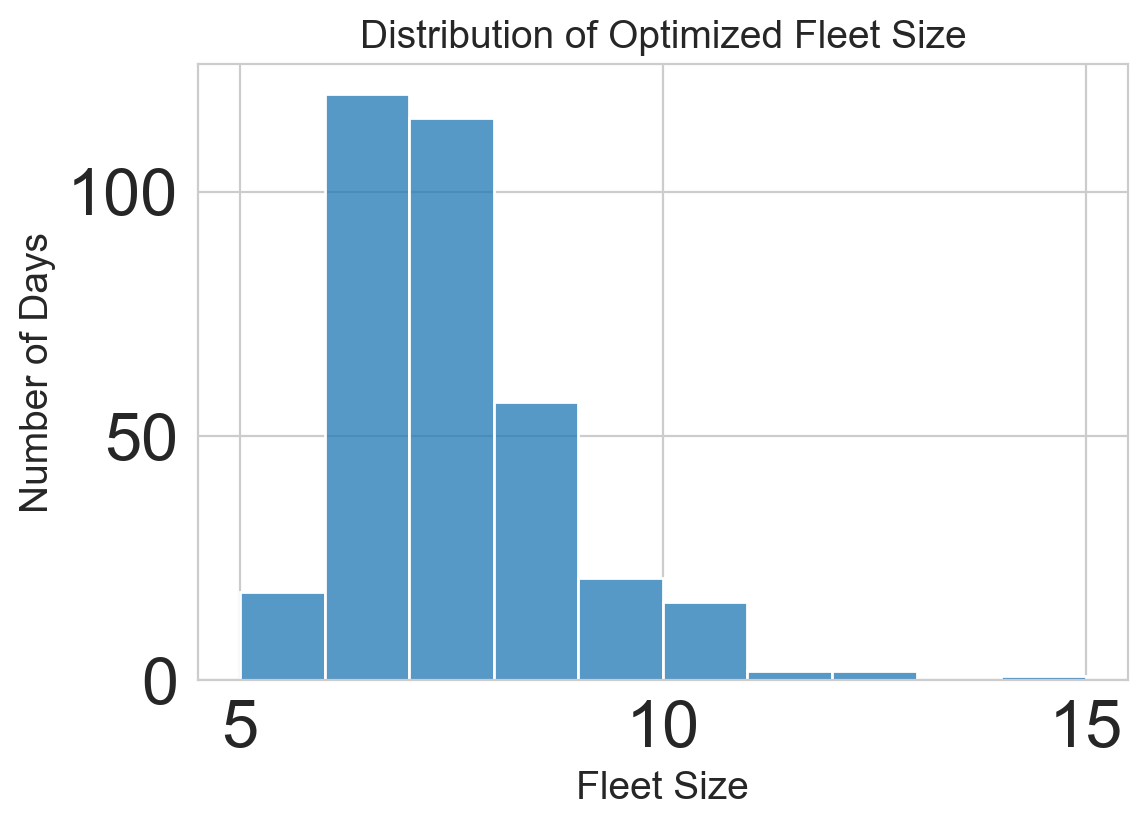

In [3]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(fleetsize_07, binwidth=1, ax=ax)
ax.set(xlabel='Fleet Size', ylabel='Number of Days', title='Distribution of Optimized Fleet Size');

In [4]:
file_list = os.listdir('output/demand_variation/fleet_op_result/alpha_7_demand_500')
all_files = []
for filename in file_list:
    if filename.endswith('_op_result.txt'):
        all_files.append(filename)


conn = sqlite3.connect('result_alpha_7_pax_500.sqlite')
for i in range(len(all_files)):
    # Load parameters
    run_id = all_files[i].split('_op_result.txt')[0]

    flight_time = np.array([[0, 10],[10, 0]]).astype(int)
    energy_consumption = np.array([[0, 10],[10, 0]]).astype(int)
    flight_distance = np.array([[0, 10],[10, 0]]).astype(int)

    # Call optimizer class and redner summary
    optimizer = FleetSizeOptimizer(flight_time, energy_consumption, schedule=f'demand_variation/schedule/alpha_7_demand_500/{run_id}.csv')
    result_path = f'demand_variation/fleet_op_result/alpha_7_demand_500/{run_id}_op_result.txt'
    optimizer.parse_result(result_path)
    optimizer.calculate_aircraft_states()
    summary = optimizer.get_summary_statistics(flight_distance, return_summary=True)

    # Save summary statistics
    line_i = np.array([summary['fleet_size'], summary['pads'][0], summary['pads'][1], summary['number_of_repositioning_flights']])
    summary_statistics = pd.DataFrame(line_i.reshape(1,4), columns=['fleet_size', 'pads_at_SFO', 'pads_at_SJC', 'number_of_repositioning_flights'])
    summary_statistics['id'] = run_id
    summary_statistics.to_sql('op_summary_statistics', conn, if_exists='append', index=False)

    # Save vertisim inputs
    vertisim_input = pd.concat([optimizer.specificc, optimizer.specificn, optimizer.specificu])
    vertisim_input.reset_index(drop=True, inplace=True)
    vertisim_input['id'] = run_id
    vertisim_input.to_sql('vertisim_input', conn, if_exists='append', index=False)



Fleet size: 7.0
Total number of pads: 11; [4 7] 
Total number of flights: 412.0; demand: 335.0; repositioning: 77.0
Total energy consumption: 1648.0 kWh
Total aircraft miles: 4120.0 mi
Total revenue aircraft miles: 3350.0
Ratio of revenue aircraft miles to aircraft miles: 0.8131067961165048
Fleet size: 6.0
Total number of pads: 9; [4 5] 
Total number of flights: 402.0; demand: 337.0; repositioning: 65.0
Total energy consumption: 1608.0 kWh
Total aircraft miles: 4020.0 mi
Total revenue aircraft miles: 3370.0
Ratio of revenue aircraft miles to aircraft miles: 0.8383084577114428
Fleet size: 7.0
Total number of pads: 12; [6 6] 
Total number of flights: 482.0; demand: 365.0; repositioning: 117.0
Total energy consumption: 1928.0 kWh
Total aircraft miles: 4820.0 mi
Total revenue aircraft miles: 3650.0
Ratio of revenue aircraft miles to aircraft miles: 0.7572614107883817
Fleet size: 7.0
Total number of pads: 12; [5 7] 
Total number of flights: 420.0; demand: 352.0; repositioning: 68.0
Total en

In [5]:

conn = sqlite3.connect('result_alpha_7_pax_500.sqlite')
query = """
SELECT *
FROM op_summary_statistics
"""
df = pd.read_sql_query(query, conn)
df



## Spill Analysis

In [24]:
spill_list = []
fleetsize_list = []

files = os.listdir('output/demand_variation/spill_op_result/alpha_7_demand_1500')
all_files = [file for file in files if file.endswith('_total_spill.txt')]

file_names = np.empty(shape=(0, 3))
for i in all_files:
    file_names = np.vstack((file_names, np.array(i.split('_')[:3])))

# 8-15  for 500
# 15-25 for 1500
# 25(27)-40 for 2500


for i in range(file_names.shape[0]):
    with open('output/demand_variation/spill_op_result/alpha_7_demand_1500/'+all_files[i], 'r') as f:
        spill = float(f.readline().split(': ')[1])
    spill_list.append(spill)
    fleetsize_list.append(int(file_names[i,2]))
    # out[int(file_names[i,2])-15].append(spill)

In [38]:
combined_spill_1500 = pd.DataFrame({'fleetsize':fleetsize_list, 'spill':spill_list})
combined_spill_1500.groupby('fleetsize')['spill'].sum()

fleetsize
15    5940.0
16    3332.0
17    1811.0
18     758.0
19     168.0
20      28.0
21       4.0
22       0.0
Name: spill, dtype: float64

<Axes: xlabel='fleetsize', ylabel='spill'>

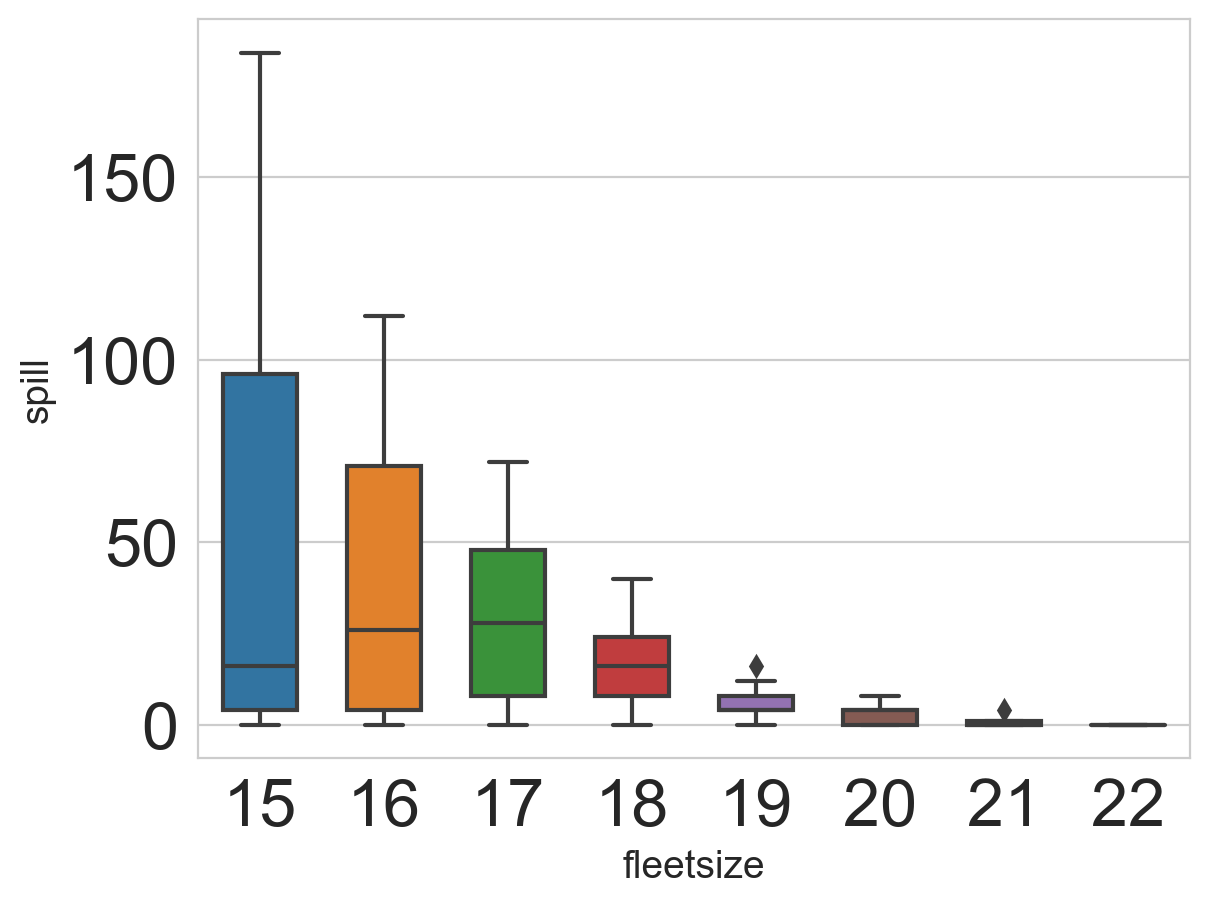

In [34]:
fig, ax = plt.subplots(dpi=200)
sns.boxplot(data=combined_spill_1500, x='fleetsize', y='spill',width=0.6, ax=ax)
# sns.boxplot(data=result, x='alpha', y='val',width=0.4, ax=ax[1])
# ax[0].set(xlabel='')
# ax[1].set(xlabel='Autoregressive Coefficient $\\alpha$')
# for i in range(2):
#     ax[i].set(ylabel='Fleet Size')
# ax[0].set_title('Distribution of Fleet Size for 365 Autorregressive Samples')


In [17]:
result = pd.DataFrame({'val':np.concatenate([fleetsize_06, fleetsize_07]), 'alpha':np.concatenate([np.repeat(0.6, len(fleetsize_06)), np.repeat(0.7, len(fleetsize_07))])})

Text(0.5, 1.0, 'Distribution of Fleet Size for 365 Autorregressive Samples')

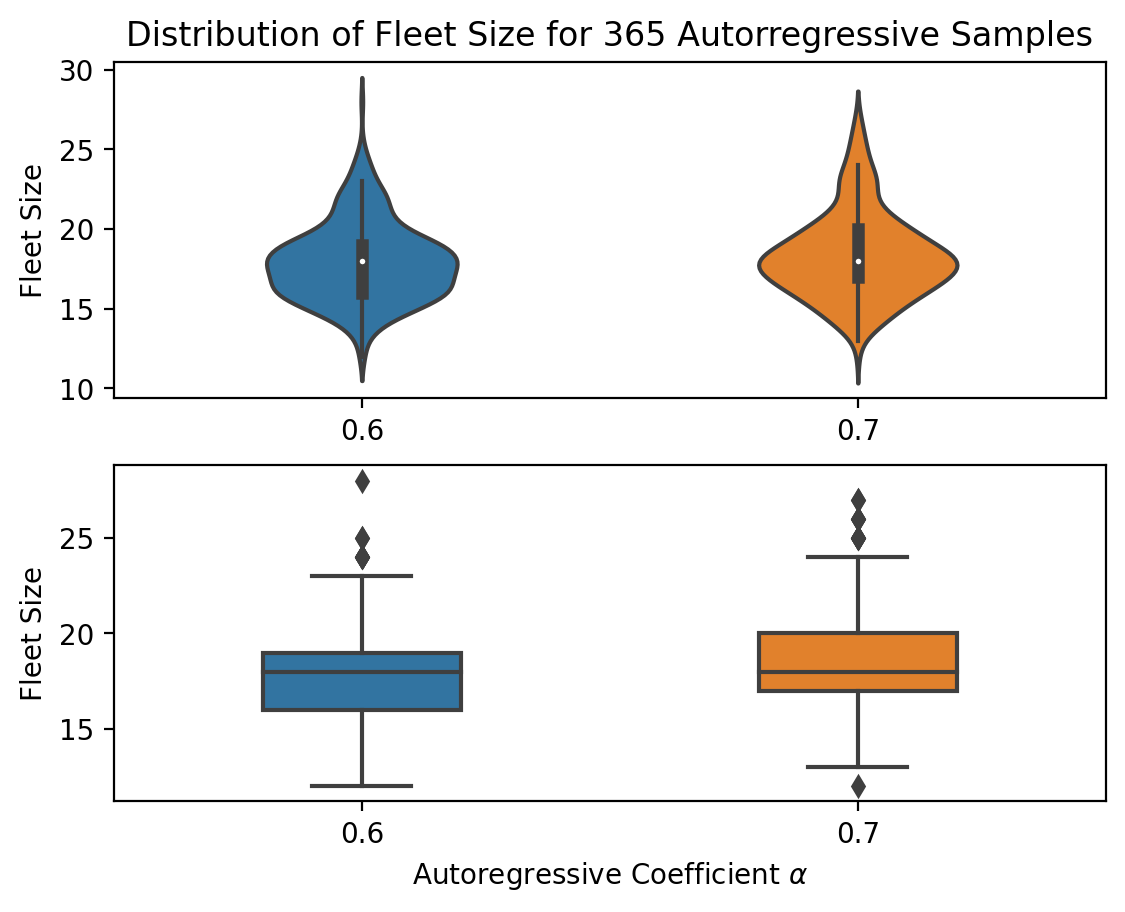

In [38]:
fig, ax = plt.subplots(nrows=2, dpi=200)
sns.violinplot(data=result, x='alpha', y='val',width=0.4, ax=ax[0])
sns.boxplot(data=result, x='alpha', y='val',width=0.4, ax=ax[1])
ax[0].set(xlabel='')
ax[1].set(xlabel='Autoregressive Coefficient $\\alpha$')
for i in range(2):
    ax[i].set(ylabel='Fleet Size')
ax[0].set_title('Distribution of Fleet Size for 365 Autorregressive Samples')


In [98]:
path = '../output/demand_variation/schedule/'

flight_demand_06 = []
flight_demand_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date

        flight_demand_06.append(pd.read_csv(path+f'{month}_{day}_6.csv').shape[0])
        flight_demand_07.append(pd.read_csv(path+f'{month}_{day}_7.csv').shape[0])

flight_demand_06 = np.array(flight_demand_06)
flight_demand_07 = np.array(flight_demand_07)


# Start here

In [109]:
import os
# os.chdir('../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import model.queueing_model
importlib.reload(model.queueing_model)
from model.queueing_model import system, one_vertiport_system
from tqdm import tqdm
import re

In [49]:
files = os.listdir('output/demand_variation/spill_op_result/alpha_7_demand_1500')
all_files = []
for file in files:
    if file.endswith('_total_spill.txt'):
        all_files.append(file)
file_names = np.empty(shape=(0, 3))
for i in all_files:
    file_names = np.vstack((file_names, np.array(i.split('_')[:3])))

In [98]:
upper_bound = np.zeros(4)
lower_bound = np.zeros(4)
for month in tqdm(range(1, 13)):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid dates
        else:
            with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_1500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
            
            for i in range(12, 16):
                if fleetsize > i:
                    s = system(i, f'input/demand_variation/schedule/alpha_7_demand_1500/num_pax_{month}_{day}.csv', f'input/demand_variation/schedule/alpha_7_demand_1500/{month}_{day}.csv')
                    upper_bound[i-12] += s.logger(True)

                    s2 = one_vertiport_system(i, f'input/demand_variation/schedule/alpha_7_demand_1500/num_pax_{month}_{day}.csv', f'input/demand_variation/schedule/alpha_7_demand_1500/{month}_{day}.csv')
                    lower_bound[i-12] += s2.logger(True)
    

  0%|          | 0/12 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [110]:
month = 1
day = 17
fleetsize = 16

In [104]:
month

1

In [111]:
a = one_vertiport_system(fleetsize, f'input/demand_variation/schedule/alpha_7_demand_1500/num_pax_{month}_{day}.csv', f'input/demand_variation/schedule/alpha_7_demand_1500/{month}_{day}.csv')

In [112]:
a.logger(True)

48.0

In [82]:
x = np.arange(10)+15
y = np.zeros(10, dtype=int)

In [83]:
for i in range(file_names.shape[0]):
    with open('output/demand_variation/spill_op_result/alpha_7_demand_1500/'+all_files[i], 'r') as f:
        spill = float(f.readline().split(': ')[1])
    y[int(file_names[i,2])-15] += spill



In [86]:
200*365

73000

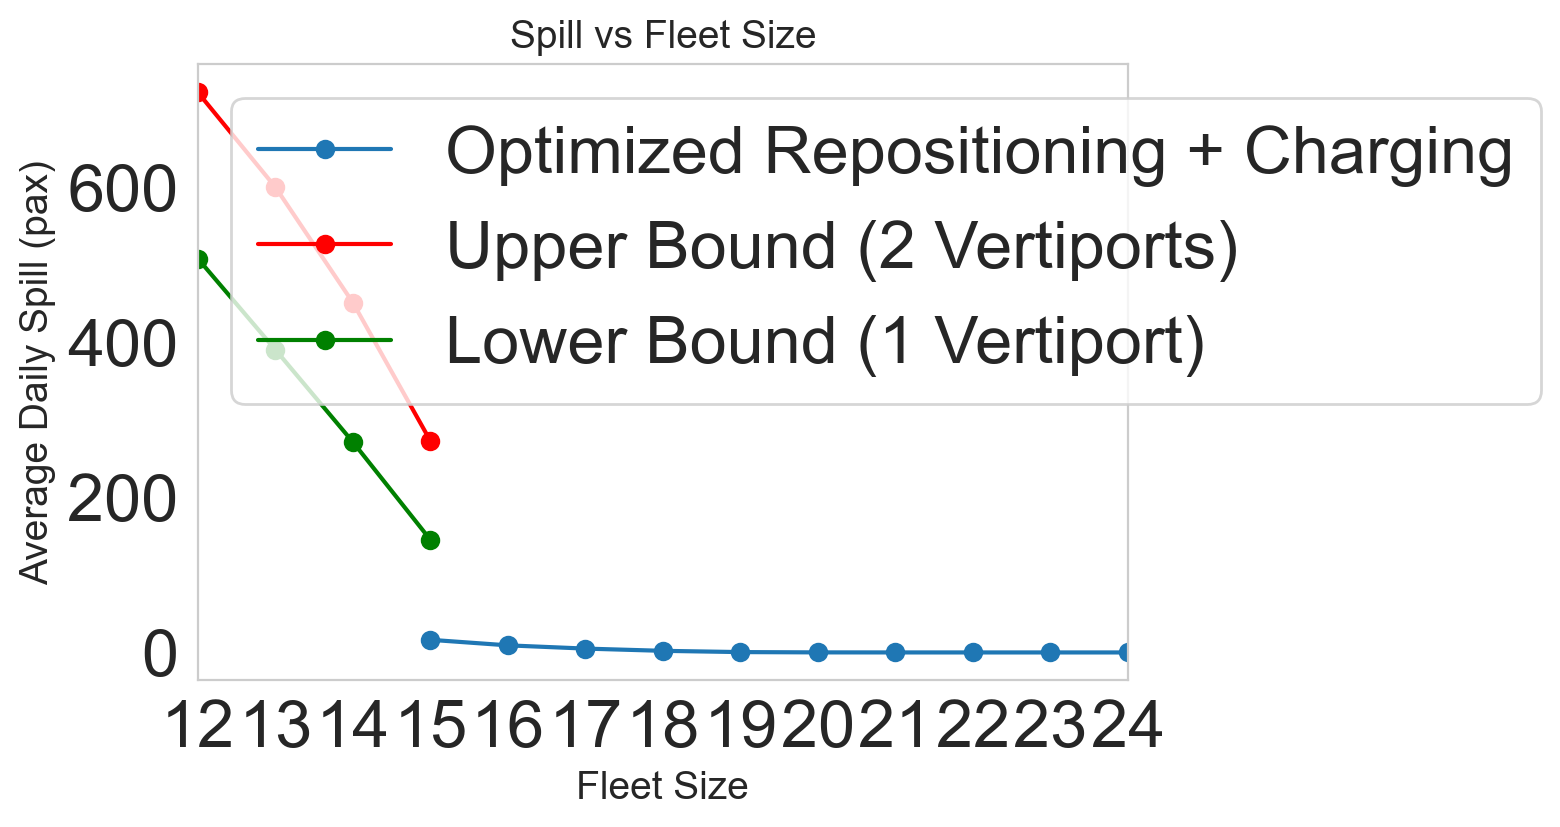

In [85]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
ax.plot(x, y/365, marker='o',
       label='Optimized Repositioning + Charging')
ax.plot(np.arange(12, 16), upper_bound/365, marker='o', color='red', 
       label='Upper Bound (2 Vertiports)')
ax.plot(np.arange(12, 16), lower_bound/365, marker='o', color='green', 
       label='Lower Bound (1 Vertiport)')
ax.set(xlabel='Fleet Size', ylabel='Average Daily Spill (pax)', title='Spill vs Fleet Size',
       xticks=np.arange(12, 25, 1),
       xlim=(12, 24))
plt.grid()
plt.legend();

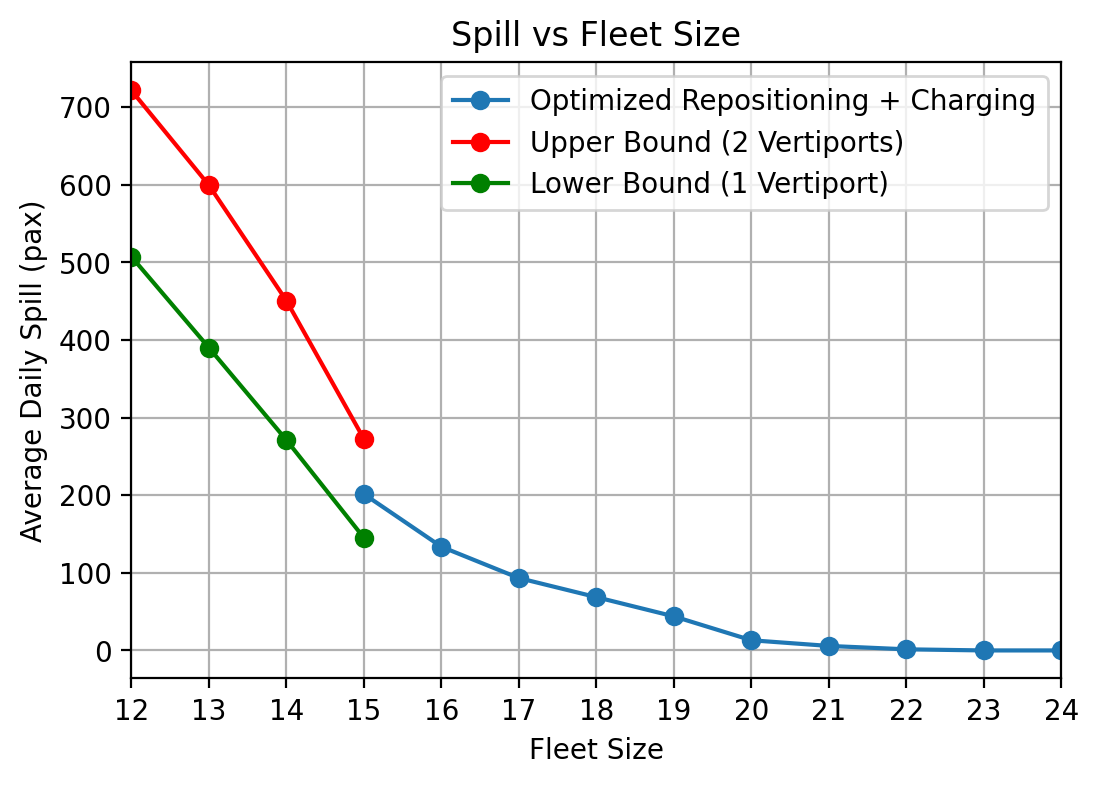

In [62]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
ax.plot(x, y/365, marker='o',
       label='Optimized Repositioning + Charging')
ax.plot(np.arange(12, 16), upper_bound/365, marker='o', color='red', 
       label='Upper Bound (2 Vertiports)')
ax.plot(np.arange(12, 16), lower_bound/365, marker='o', color='green', 
       label='Lower Bound (1 Vertiport)')
ax.set(xlabel='Fleet Size', ylabel='Average Daily Spill (pax)', title='Spill vs Fleet Size',
       xticks=np.arange(12, 25, 1),
       xlim=(12, 24))
plt.grid()
plt.legend();

In [ ]:
# beta * F to give a cost of acquiring a new aircraft
# full process documented
# seat capacity of a flght / seats of the entire year * (365*1500)

## Get a new demand profile

In [1]:
from UAM_Schedule import UAM_Schedule

In [2]:
sche = UAM_Schedule('LAX_ind.csv', 'T_F41SCHEDULE_B43.csv')
schedule, pax_arrival_times, num_pax = sche.get_one_day(7, 7)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)
import numpy as np

lax_dtla_sche = schedule[schedule['od'] == 'LAX_DTLA']
dtla_lax_sche = schedule[schedule['od'] == 'DTLA_LAX']

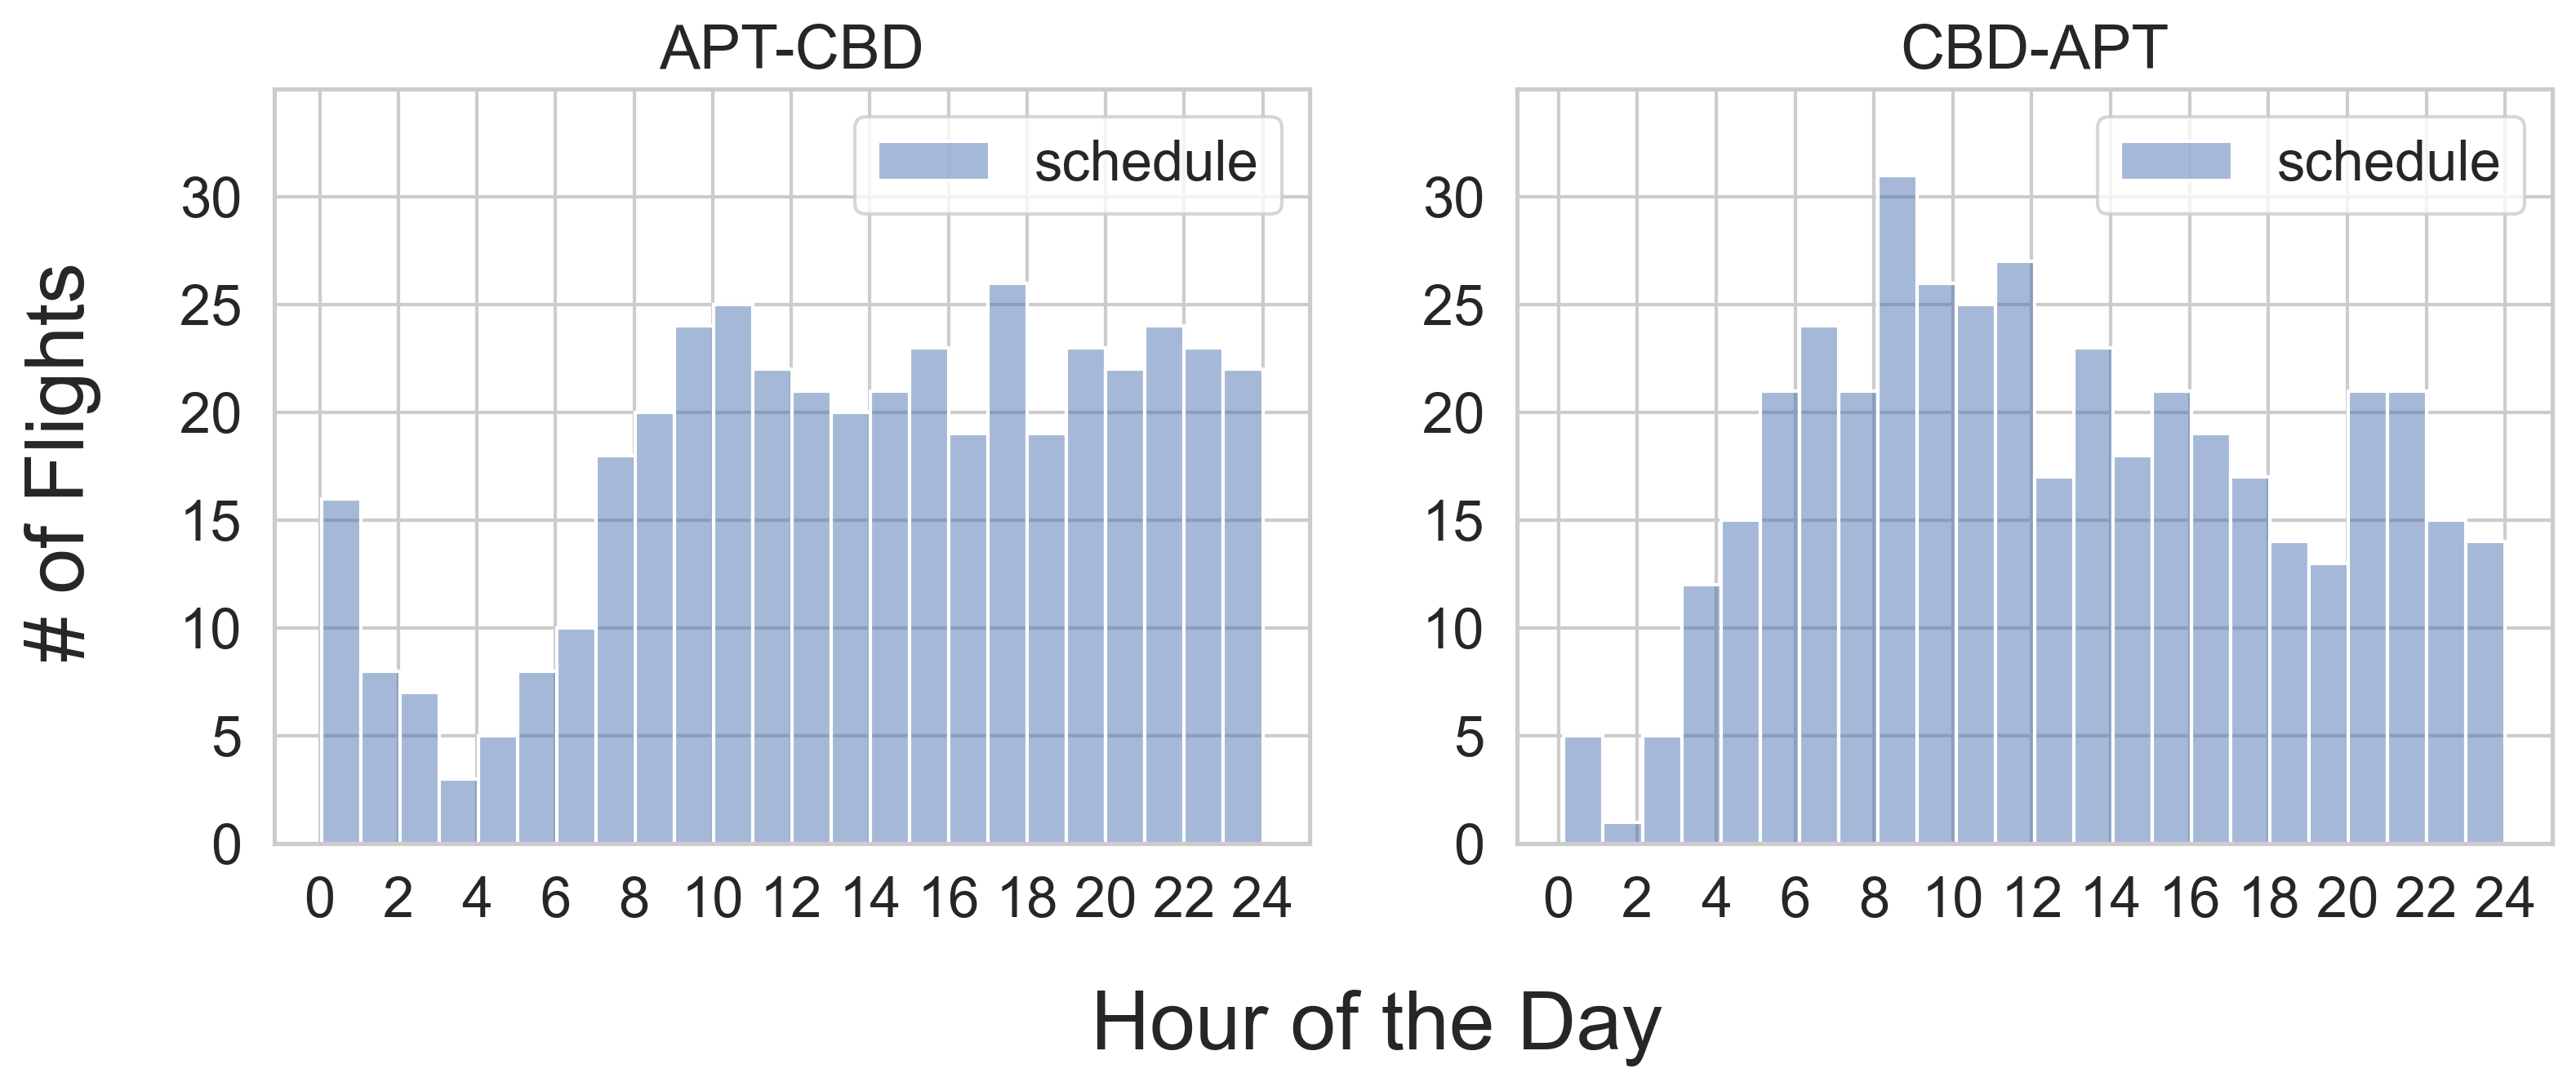

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(lax_dtla_sche, bins=24, ax=ax[0], label='LAX-DTLA')
sns.histplot(dtla_lax_sche, bins=24, ax=ax[1], label='DTLA-LAX', color='orange')

for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
              xticks=np.arange(0,1560,120), 
              xticklabels=np.arange(0,26,2),
              yticks=np.arange(0,32,5),
              ylim=(0,35))

ax[0].set(title='APT-CBD')
ax[1].set(title='CBD-APT')
fig.text(0.5, -0.1, 'Hour of the Day', ha='center', fontsize=24)
# fig.text(0.5, 1, 'Hourly Scheduled Departures at Vertiports \n (5min threshold)', ha='center', fontsize=24)
fig.text(0.04, 0.5, '# of Flights', va='center', rotation='vertical', fontsize=24)
plt.gcf().set_dpi(300)

In [7]:
schedule.to_csv('../input/ICRAT/schedule_1500pax_5min_0125.csv', index=False)
num_pax.to_csv('../input/ICRAT/num_pax_1500pax_5min_0125.csv', index=False)